Imports and data.

In [1]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
print('load data')
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)
reactions = dg.collection.ReactionCollection([dg.reaction.LazyReaction(r.template, id=r.id) for r in reactions])

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/out/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

load data


Define library designer.

In [2]:
from dgym.envs.library_designer import LibraryDesigner

library_designer = LibraryDesigner(
    reactions,
    building_blocks,
    fingerprints
)

Reconstruct a molecule as a generator.

### Construct logic of new Library Designer

In [108]:
import inspect

def retrosynthesize(molecule, protect=False):
    
    # Base cases
    if inspect.isgenerator(molecule):
        return molecule
    
    elif not molecule.reactants:
        return molecule
    
    # Recursive case: Retrosynthesize each reactant
    retrosynthesized_reactants = [retrosynthesize(reactant) for reactant in molecule.reactants]
        
    # Use the reaction to reconstruct the original molecule from its reactants
    output = molecule.reaction.run(retrosynthesized_reactants, protect=protect)
    
    return output

In [109]:
from dgym.envs.library_designer import AnalogGenerator

generator = AnalogGenerator(building_blocks, fingerprints)

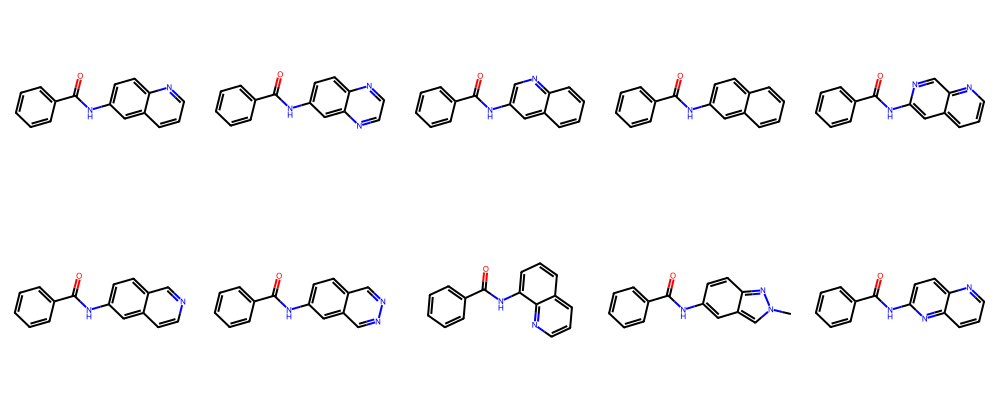

In [110]:
import itertools

# # Deepcopy original molecule
from copy import deepcopy
molecule = deepcopy(deck[31])

# Perform reactions
size = 10
products = []
for reaction, reactants in library_designer.match_reactions(molecule):
    
    # Replace reactants with analog generators
    molecule.reaction = reaction
    molecule.reactants = reactants
    molecule.reactants[1] = generator.generate(reactants[1], temperature=0.0)[0]
    
    # Create lazy loader for molecule analogs
    analogs = retrosynthesize(molecule, protect=False)
    
    # Run reaction
    while len(products) < size:
        products.append(next(analogs))

from rdkit.Chem.Draw import MolsToGridImage
MolsToGridImage([p.mol for p in products], molsPerRow=5)

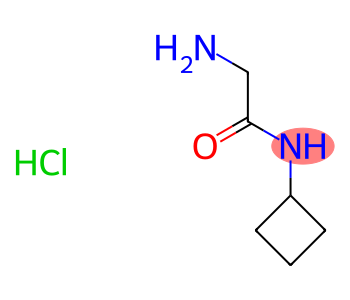

In [515]:
from rdkit.Chem import Draw
from io import BytesIO
from PIL import Image

d2d = Draw.MolDraw2DCairo(350, 300)

d2d.DrawMolecule(products[0].reactants[1].mol, legend='', highlightAtoms=[5])
d2d.FinishDrawing()
bio = BytesIO(d2d.GetDrawingText())
Image.open(bio)